In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
# Load the battery dataset
B0005 = loadmat('B0005.mat', squeeze_me=True, struct_as_record=False)
B0005.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])

In [4]:
cycles = B0005['B0005'].cycle

In [5]:
cycles[0]._fieldnames

['type', 'ambient_temperature', 'time', 'data']

In [6]:
cycles[0].type

'charge'

In [7]:
discharge_cycles = []

for cycle in cycles:
    if cycle.type == 'discharge':
        discharge_cycles.append(cycle)

len(discharge_cycles)
discharge_cycles[0]._fieldnames

['type', 'ambient_temperature', 'time', 'data']

In [8]:
discharge_cycles[0].data._fieldnames

['Voltage_measured',
 'Current_measured',
 'Temperature_measured',
 'Current_load',
 'Voltage_load',
 'Time',
 'Capacity']

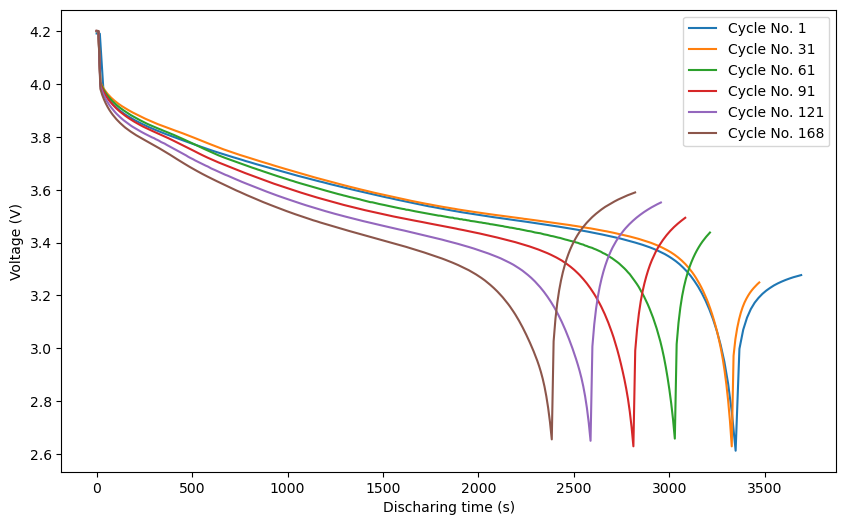

In [9]:
selected_cycles = [0, 30, 60, 90, 120, 167]

fig, ax = plt.subplots(figsize=(10,6))

for i in selected_cycles:
    
    voltage = discharge_cycles[i].data.Voltage_measured
    time = discharge_cycles[i].data.Time

    ax.plot(time, voltage, label=f'Cycle No. {i+1}')

ax.set_xlabel('Discharing time (s)')
ax.set_ylabel('Voltage (V)')

plt.legend()
plt.show()

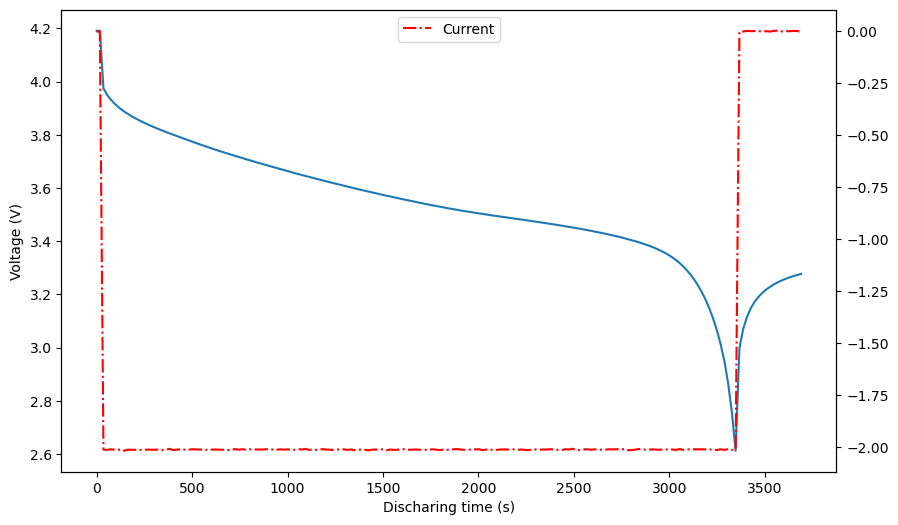

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

voltage = discharge_cycles[0].data.Voltage_measured
time = discharge_cycles[0].data.Time
current = discharge_cycles[0].data.Current_measured

ax.plot(time, voltage, label=f'Cycle No. {1}')
twin = ax.twinx()
twin.plot(time, current, label='Current', linestyle='-.', color='r')

ax.set_xlabel('Discharing time (s)')
ax.set_ylabel('Voltage (V)')

plt.legend()
plt.show()

In [11]:
# Make a mask to filter out all bouncing back values
threshold = current < -0.01

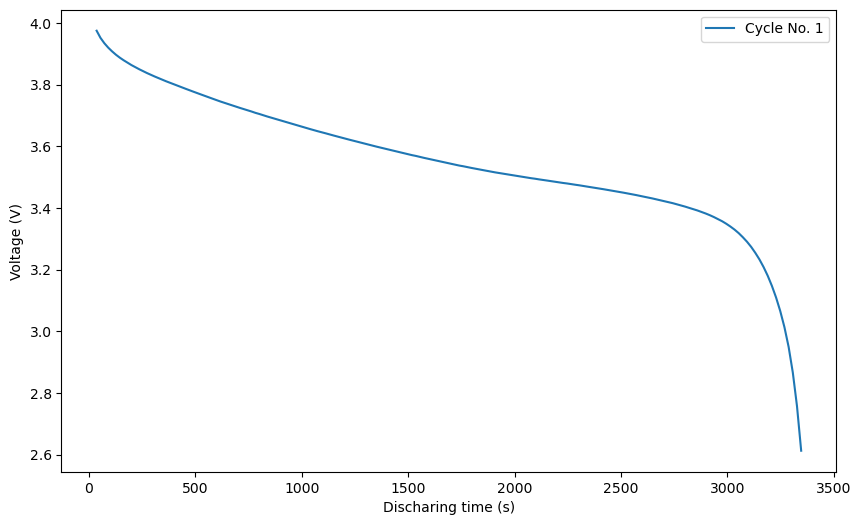

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

voltage = discharge_cycles[0].data.Voltage_measured[threshold]
time = discharge_cycles[0].data.Time[threshold]
#current = discharge_cycles[0].data.Current_measured

ax.plot(time, voltage, label=f'Cycle No. {1}')
#twin = ax.twinx()
#twin.plot(time, current, label='Current', linestyle='-.', color='r')

ax.set_xlabel('Discharing time (s)')
ax.set_ylabel('Voltage (V)')

plt.legend()
plt.show()

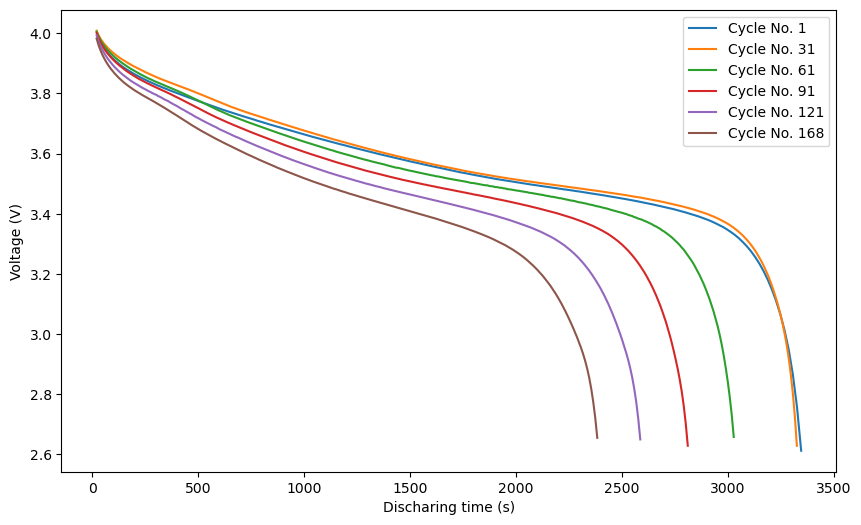

In [13]:
selected_cycles = [0, 30, 60, 90, 120, 167]

fig, ax = plt.subplots(figsize=(10,6))

for i in selected_cycles:
    
    current = discharge_cycles[i].data.Current_measured
    
    threshold = current < -0.01
    
    voltage = discharge_cycles[i].data.Voltage_measured[threshold]
    time = discharge_cycles[i].data.Time[threshold]

    ax.plot(time, voltage, label=f'Cycle No. {i+1}')

ax.set_xlabel('Discharing time (s)')
ax.set_ylabel('Voltage (V)')

plt.legend()
plt.show()

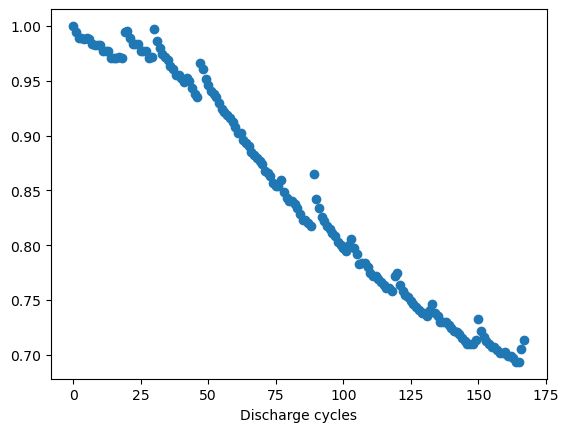

In [14]:
fig, ax = plt.subplots()

initial_capcity = discharge_cycles[0].data.Capacity
soh = []

for discharge_cycle in discharge_cycles:
    cycle_soh = discharge_cycle.data.Capacity / initial_capcity
    soh.append(cycle_soh)

ax.scatter(np.arange(168), soh)

ax.set_xlabel('Discharge cycles')
plt.show()

In [15]:
# Voltage -> max, min, mean, range
# Temperature -> -> max, min, mean, range
# Time
# Energy
# 10 features
features = []

for discharge_cycle in discharge_cycles:

    current = discharge_cycle.data.Current_measured
    threshold = current < -0.01
    volt_max = np.max(discharge_cycle.data.Voltage_measured[threshold])
    volt_min = np.min(discharge_cycle.data.Voltage_measured[threshold])
    volt_mean = np.mean(discharge_cycle.data.Voltage_measured[threshold])
    volt_range = volt_max - volt_min
    
    temp_max = np.max(discharge_cycle.data.Temperature_measured[threshold])
    temp_min = np.min(discharge_cycle.data.Temperature_measured[threshold])
    temp_mean = np.mean(discharge_cycle.data.Temperature_measured[threshold])
    temp_range = temp_max - temp_min

    time = discharge_cycle.data.Time[threshold][-1] - discharge_cycle.data.Time[threshold][0]
    energy = 2 * np.trapezoid(discharge_cycle.data.Voltage_measured[threshold], discharge_cycle.data.Time[threshold])

    feature = [volt_max, volt_min, volt_mean, volt_range, temp_max, temp_min, temp_mean, temp_range, time, energy]
    features.append(feature)

X = np.array(features)

X.shape

(168, 10)

In [16]:
y = np.array(soh)
y.shape

(168,)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Random shuffle using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_input = X_train_scaled

In [18]:
def ReLU(x):
    return np.maximum(0, x)


class Layer:

    def __init__(self, neurons_in, neurons_out):
        self.weights = np.random.randn(neurons_in, neurons_out)
        self.bias = np.random.randn(neurons_out)

    def forward(self, X_input):
        self.z = np.dot(X_input,self.weights) + self.bias
        self.a = ReLU(self.z)
        return self.a


layer1 = Layer(10, 8)
a1 = layer1.forward(X_input)

layer2 = Layer(8, 4)
a2 = layer2.forward(a1)


layer3 = Layer(4, 1)
a3 = layer3.forward(a2) # final output
z3 = layer3.z


In [19]:
X_input.shape

(112, 10)

In [20]:
# Construct ANN layers and forward propagation

def ReLU(x):
    return np.maximum(0, x)

def Sigmoid(x):
    return 1 / (1 + np.exp(-x))


class Layer:
    
    # Construct a Layer object
    def __init__(self, neurons_in, neurons_out, last_layer=False):
        self.weights = np.random.randn(neurons_in, neurons_out)
        self.bias = np.random.randn(neurons_out)
        self.last_layer = last_layer

    # Layer forward propagation
    def forward(self, X_input):
        self.z = np.dot(X_input, self.weights) + self.bias

        if self.last_layer == True:
            self.activation = Sigmoid(self.z)
            return self.activation
        else:
            self.activation = ReLU(self.z)
            return self.activation

In [22]:
# Define the cost/loss function of ANN

def cost(predicted, real):
    Cost = np.mean(np.sum((predicted - real.reshape(-1,1))**2))
    return Cost

Cost = np.mean(np.sum((a3 - y_train.reshape(-1,1))**2))
Cost

np.float64(71120.7378478073)

In [30]:
# Backpropagation, update the weights to the direction of negative gradient

def Sigmoid_derivative(x):
    return Sigmoid(x) * (1 - Sigmoid(x))

def ReLU_derivative(x):
    return np.where(x<=0, 0, 1)

# Learning rate
learning_rate = 0.01

# Number of batch size
N = X_input.shape[0]

def backpropagation(layer1, layer2, layer3, a1, a2, a3, N, learning_rate=0.001):

    
    W1 = layer1.weights
    b1 = layer1.bias
    z1 = layer1.z
    W2 = layer2.weights
    b2 = layer2.bias
    z2 = layer2.z
    W3 = layer3.weights
    b3 = layer3.bias
    z3 = layer3.z

    # dCost/dW3 = dCost/da3 * da3/dz3 * dz/dW3
    dCost_da3 = (2 / N) * (a3 - y_train.reshape(-1,1))
    da3_dz3 = Sigmoid_derivative(z3)
    dz3_dW3 = a2
    dW3 = np.dot(a2.T, dCost_da3 * da3_dz3)
    db3 = np.mean(dCost_da3 * da3_dz3, axis=0)
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    
    # dCost/dW2 = dCost/da3 * da3/dz3 * dz3/da2 * da2/dz2 * dz2/dW2
    dz3_da2 = layer3.weights
    da2_dz2 = ReLU_derivative(z2)
    dz2_dW2 = a1
    dW2 = np.dot(dz2_dW2.T, np.dot((dCost_da3 * da3_dz3), dz3_da2.T) * da2_dz2)
    db2 = np.mean(np.dot((dCost_da3 * da3_dz3), dz3_da2.T) * da2_dz2, axis=0)
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    # dCost/dW1 = dCost/da3 * da3/dz3 * dz3/da2 * da2/dz2 * dz2/da1 * da1/dz1 * dz1/dW1
    dz2_da1 = layer2.weights
    da1_dz1 = ReLU_derivative(z1)
    dz1_dW1 = X_input
    dW1 = np.dot(dz1_dW1.T, np.dot((np.dot((dCost_da3 * da3_dz3), dz3_da2.T) * da2_dz2), dz2_da1.T) * da1_dz1)
    db1 = np.mean(np.dot((np.dot((dCost_da3 * da3_dz3), dz3_da2.T) * da2_dz2), dz2_da1.T) * da1_dz1, axis=0)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    return W1, b1, W2, b2, W3, b3


In [31]:
# Training process

layer1 = Layer(10, 5)
a1 = layer1.forward(X_input)

layer2 = Layer(5, 2)
a2 = layer2.forward(a1)

layer3 = Layer(2, 1, last_layer=True)
a3 = layer3.forward(a2)

Cost = cost(a3, y_train)

cost_list = [Cost]

epochs = range(10000)

for epoch in epochs:
    results = backpropagation(layer1, layer2, layer3, a1, a2, a3, X_input.shape[0])
    

    a1 = layer1.forward(X_input)
    a2 = layer2.forward(a1)
    a3 = layer3.forward(a2)

    Cost = cost(a3, y_train)
    cost_list.append(Cost)
    
    if epoch % 1000 == 0:
        print(Cost)

21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908
21.620022414191908


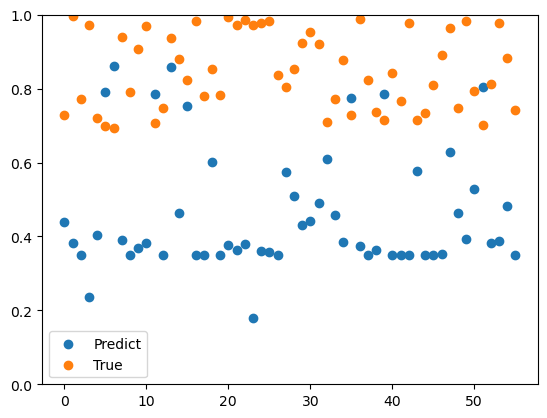

In [33]:
# Compare predicted results with true values
a1 = layer1.forward(X_test_scaled)
a2 = layer2.forward(a1)
a3 = layer3.forward(a2)

r = range(56)
fig, ax = plt.subplots()

ax.scatter(r, a3, label='Predict')
ax.scatter(r, y_test, label='True')
ax.set_ylim(0,1)
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


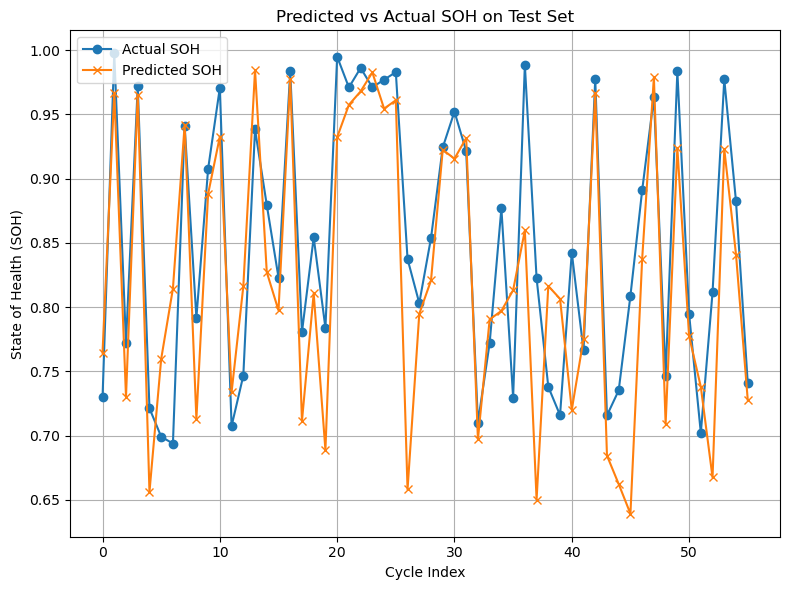

In [35]:
# Build the same ANN model using tensorflow, except for adding 1 more hidden layer and using
# different number of neurons in each hidden layer. 10 -> 6 -> 4 -> 2 -> 1

import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Input(shape=(10,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # use 20% of training data for validation
    verbose=0
)

# Predict SOH on the test set
# y_pred = model.predict(X_test_scaled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Plot actual vs predicted SOH
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual SOH', marker='o')
plt.plot(y_pred, label='Predicted SOH', marker='x')

plt.title('Predicted vs Actual SOH on Test Set')
plt.xlabel('Cycle Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

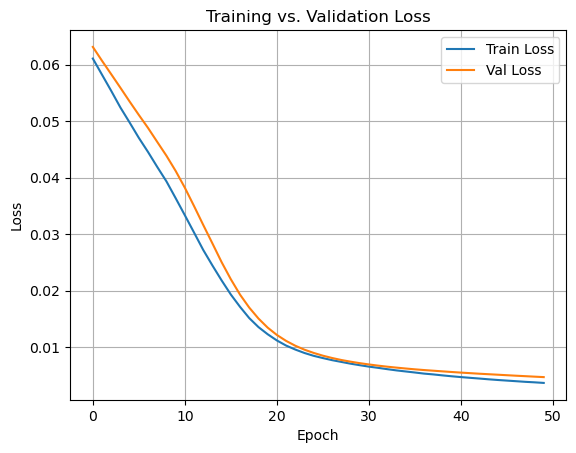

In [36]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate test result mean absolut error
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae:.4f}")